# 1. loading datasets

Training has to be done with dropout as data is not always present

In [3]:
import torch
import pandas as pd
import numpy as np
import time
import joblib
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F




In [4]:

from torch import nn 

# Check PyTorch version
print("PyTorch version:", torch.__version__)

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# Get current CUDA device index (if available)
if torch.cuda.is_available():
    print("Current CUDA device index:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("No CUDA devices found.")
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


PyTorch version: 2.5.0+cu118
CUDA available: True
Current CUDA device index: 0
CUDA device name: NVIDIA GeForce RTX 4070 SUPER


In [5]:
# Update with the correct path
# file_path = './Data/12_Sep_Readings/combined_data.csv'  
# file_path = './Data/15_Nov_Readings/augmented_rssi_dataset.csv'
file_path = './Data/25-02-10/cleaned_df.csv'
model_path = './models/CNN'
cleaned_df = pd.read_csv(file_path)

In [6]:
cleaned_df

,Tx_0 RSSI,Tx_1 RSSI,Tx_2 RSSI,Tx_3 RSSI,Tx_4 RSSI,Tx_5 RSSI,Tx_6 RSSI,Tx_7 RSSI,X_Coord,Y_Coord
0,-61,-74,-79,127,-81,-78,127,-84,0,0
1,-61,-73,-78,-71,127,-78,127,127,0,0
2,-62,-75,-78,-72,-79,127,-84,127,0,0
3,-61,-73,-80,-71,-83,-78,127,127,0,0
4,-61,-75,-78,-71,-84,-78,-84,-86,0,0
...,...,...,...,...,...,...,...,...,...,...
6395,-79,-69,-81,-74,-70,-61,-78,-68,6,0
6396,-77,-69,-77,-71,-70,-61,-79,-67,6,0
6397,-77,-69,-81,-73,-70,-61,-79,-66,6,0
6398,-80,-69,-77,-72,-71,-61,-76,-67,6,0


In [7]:
from common_utils import preprocess_dataset

# X = cleaned_df[['Tx_0 RSSI', 'Tx_1 RSSI', 'Tx_2 RSSI', 'Tx_3 RSSI', 'Tx_4 RSSI', 'Tx_5 RSSI', 'Tx_6 RSSI', 'Tx_7 RSSI']]
# X = cleaned_df[['Tx_0 RSSI_Avg', 'Tx_1 RSSI_Avg', 'Tx_2 RSSI_Avg', 'Tx_3 RSSI_Avg', 'Tx_4 RSSI_Avg', 'Tx_5 RSSI_Avg', 'Tx_6 RSSI_Avg', 'Tx_7 RSSI_Avg']]
X = cleaned_df[['Tx_0 RSSI', 'Tx_1 RSSI', 'Tx_2 RSSI', 'Tx_3 RSSI', 'Tx_4 RSSI', 'Tx_5 RSSI', 'Tx_6 RSSI', 'Tx_7 RSSI']]
Y = cleaned_df[['X_Coord', 'Y_Coord']]



In [16]:
grid_data = {}

for index, row in cleaned_df.iterrows():
    x, y = int(row['X_Coord']), int(row['Y_Coord'])
    
    # Create an empty list for this location if not already present
    if (x, y) not in grid_data:
        grid_data[(x, y)] = []
    
    # Store the full set of RSSI values (Tx_0 to Tx_7)
    grid_data[(x, y)].append(row[X.columns].values)

# Convert to a structured NumPy array with fixed size (8x8 locations, 8 transmitters, 8 sequential samples)
grid_matrix = np.full((8, 8, 8, 8), np.nan)  # Shape: (8x8 grid, 8 Tx, 8 samples)

for (x, y), rssi_values in grid_data.items():
    rssi_array = np.array(rssi_values)  # Convert to NumPy array
    
    # Ensure only 8 samples are taken per location
    if rssi_array.shape[0] >= 8:
        rssi_array = rssi_array[:8].T  # Take first 8 samples and Transpose (Tx, Samples)
    else:
        # If less than 8, pad with NaNs
        rssi_array = np.pad(rssi_array, ((0, 8 - rssi_array.shape[0]), (0, 0)), mode='constant', constant_values=np.nan).T

    grid_matrix[y, x, :, :] = rssi_array  # Store in grid (y, x to align with imshow)

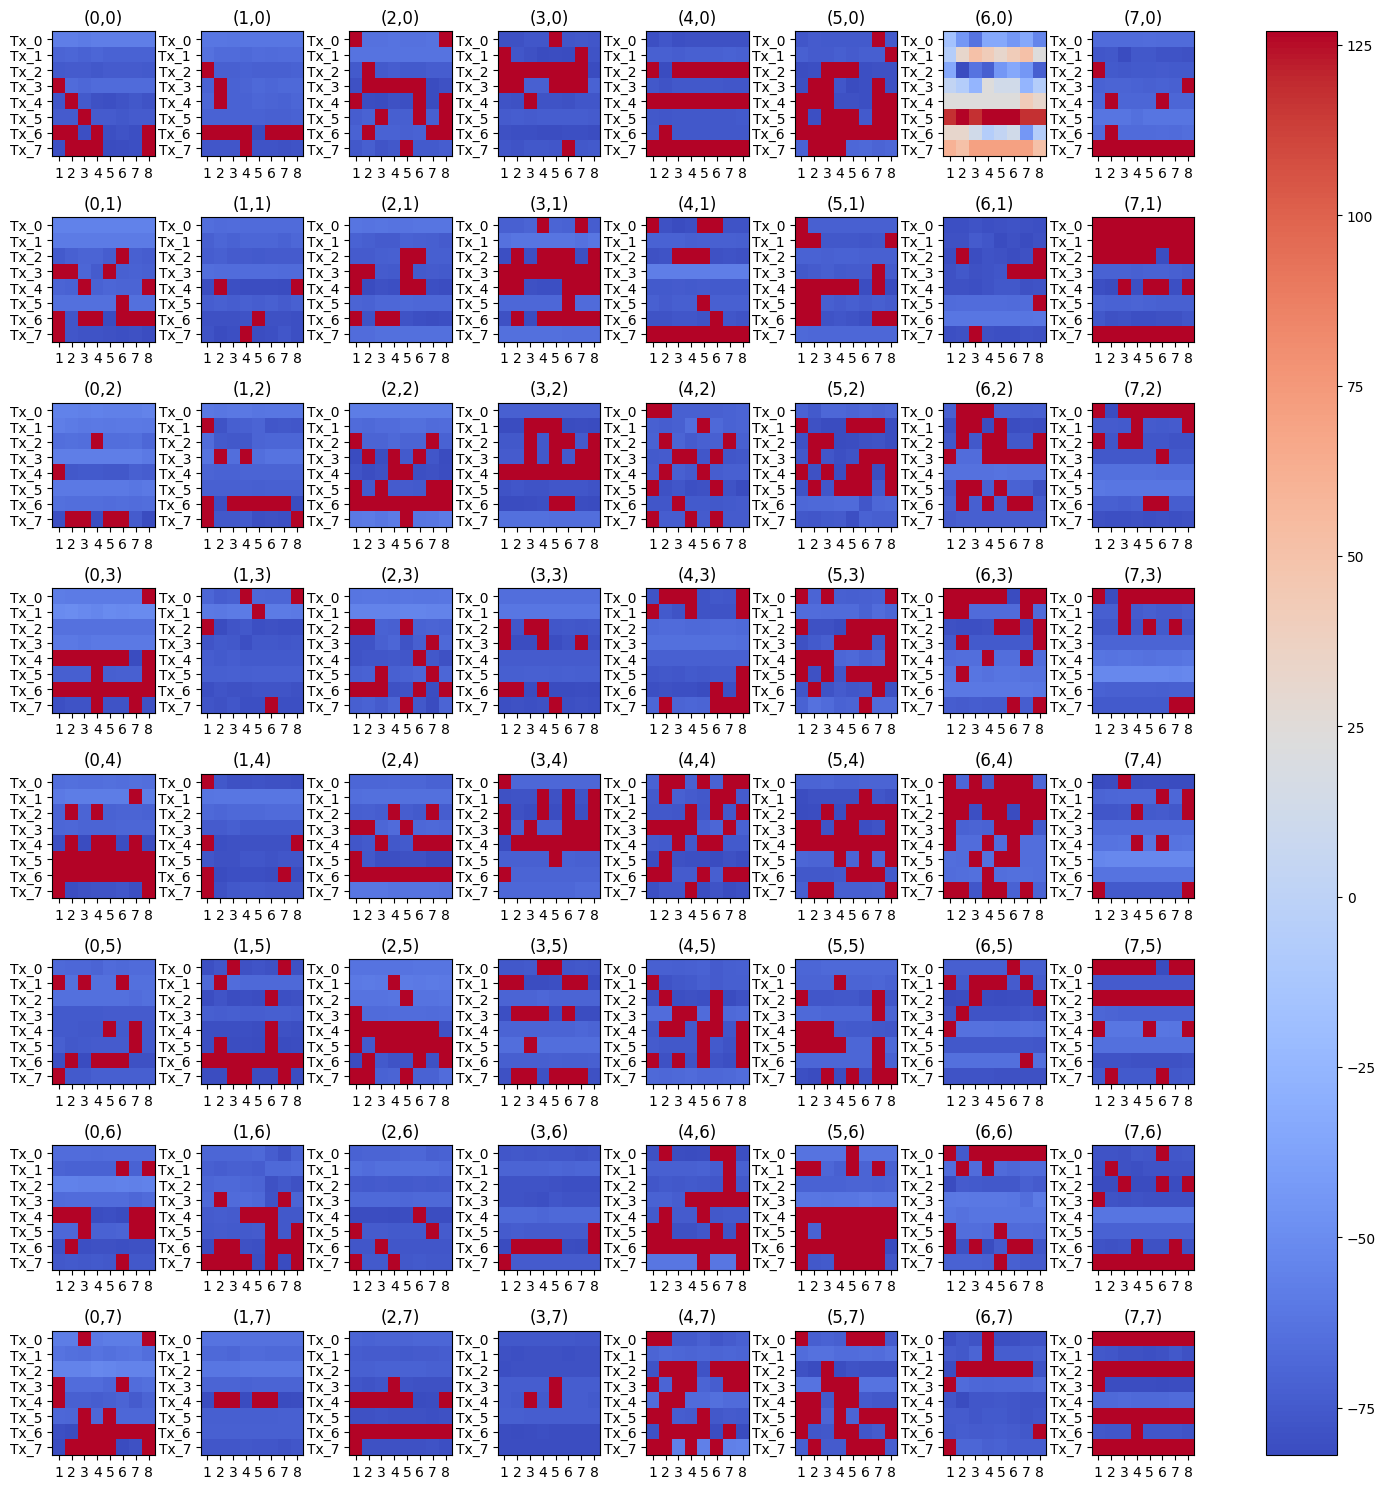

In [17]:
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for y in range(8):
    for x in range(8):
        ax = axes[y, x]
        im = ax.imshow(grid_matrix[y, x, :, :], cmap="coolwarm", interpolation="nearest", aspect="auto")
        ax.set_title(f"({x},{y})")  # Grid location
        ax.set_xticks(range(8))
        ax.set_xticklabels(range(1, 9))  # Sample index
        ax.set_yticks(range(8))
        ax.set_yticklabels([f"Tx_{i}" for i in range(8)])  # Transmitters

plt.tight_layout()
plt.colorbar(im, ax=axes.ravel().tolist())  # Add colorbar
plt.show()

# 2. NN model

In [46]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 3 * 3, 128)  # Adjusted input size
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # No pooling here
        x = F.relu(self.conv2(x))  # No pooling here
        x = x.view(x.size(0), -1)  # Flatten for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [47]:
model = CNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [48]:
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [49]:
# Training loop
num_epochs = 200
patience = 40
best_val_loss = float('inf')
epochs_without_improvement = 0

In [50]:

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")


Epoch [10/200], Train Loss: 10.2467, Val Loss: 8.9317
Epoch [20/200], Train Loss: 6.9483, Val Loss: 6.3740
Epoch [30/200], Train Loss: 5.9511, Val Loss: 5.9115
Epoch [40/200], Train Loss: 5.4566, Val Loss: 5.4580
Epoch [50/200], Train Loss: 5.2864, Val Loss: 5.2724
Epoch [60/200], Train Loss: 5.1147, Val Loss: 5.0926
Epoch [70/200], Train Loss: 4.8850, Val Loss: 4.8579
Epoch [80/200], Train Loss: 4.5879, Val Loss: 4.5682
Epoch [90/200], Train Loss: 4.3152, Val Loss: 4.3027
Epoch [100/200], Train Loss: 4.0750, Val Loss: 4.0580
Epoch [110/200], Train Loss: 3.8366, Val Loss: 3.8147
Epoch [120/200], Train Loss: 3.5970, Val Loss: 3.5759
Epoch [130/200], Train Loss: 3.3407, Val Loss: 3.3072
Epoch [140/200], Train Loss: 3.0527, Val Loss: 2.9956
Epoch [150/200], Train Loss: 2.7492, Val Loss: 2.6588
Epoch [160/200], Train Loss: 2.4741, Val Loss: 2.3522
Epoch [170/200], Train Loss: 2.2617, Val Loss: 2.1227
Epoch [180/200], Train Loss: 2.0912, Val Loss: 1.9660
Epoch [190/200], Train Loss: 1.9310,

In [51]:
# Set model to evaluation mode
model.eval()

# Choose a sample input from the test set
# Assuming you have already split your data into X_test (input) and y_test (targets)
inputs, targets = X_test, y_test  # Replace X_test, y_test with your actual test set

# Select only the first 10 samples from the batch
inputs = inputs[:10]
actual_targets = targets[:10]  # Corresponding actual coordinates for the test set

# Reshape inputs to fit the model (if needed)
# inputs = inputs.unsqueeze(1)  # Add channel dimension, shape: (10, 1, 8, 20)

# Perform the forward pass
with torch.no_grad():
    # Forward pass to get the model's predictions
    preds = model(inputs)  # Output shape: (10, 2) for X_Coord and Y_Coord predictions

predicted_coords = torch.round(preds).to(torch.int)
# Display predicted coordinates (X, Y) and actual targets
print("Predicted X and Y coordinates:")
print(predicted_coords.numpy())  

print("\nActual X and Y coordinates:")
print(actual_targets.numpy()) 


Predicted X and Y coordinates:
[[4 4]
 [6 2]
 [2 3]
 [5 2]
 [6 2]
 [3 3]
 [6 6]
 [6 4]
 [4 0]
 [6 6]]

Actual X and Y coordinates:
[[7. 6.]
 [7. 3.]
 [3. 4.]
 [4. 6.]
 [4. 3.]
 [2. 1.]
 [6. 4.]
 [6. 4.]
 [5. 1.]
 [6. 7.]]


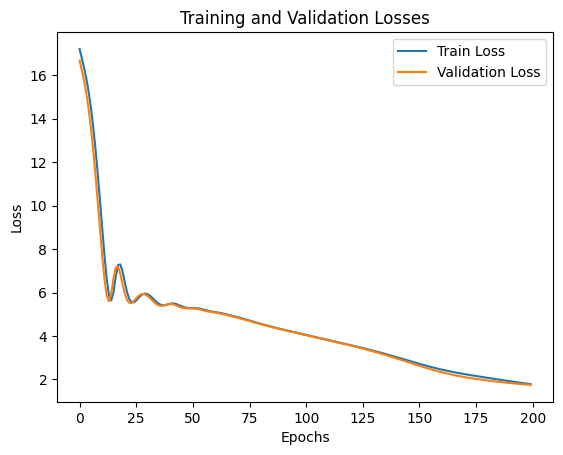

In [52]:
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()